# Network analysis - Ordinary Least Squares Regression.

**Context**

This notebook loads in cell-type specifc Gene Regulatory Networks (GRNs) with the format: 'source' - 'target'. Where source refers to a Transcription Factor (TF) and target refers to a gene. The relationship i.e. row indicates that the TF under 'source' is targeting the gene under 'target' for activation of transcription. These celltype-specifc GRNs were created using the pipeline 'GRN_reconstruction_whole_data' by Abdool Al-Khaledi (a.g.al-khaledi@students.uu.nl). The pipeline takes as input a CellxGene Matrix and exports a file for each celltype containing the GRN in a 'source' - 'target' table format. This notebook carries out the subsequent part of the analysis: Modeling ASD activity as a function of total network activity and Time.

**Objective**

The purpose of this notebook is to visualize ASD and GRN activity over time. As well model ASD activity as a function of GRN activity and time to regress out these variables on ASD regulon activity.

**Summary**

The notebook begins by loading the GRN activity and ASD regulon activity. We quantify metrics for each time point including measures of GRN activity, ASD regulon activity and control TF activity. These metrics are then combined into 1 dataframe and melted into long format for the purpose of the regression analysis. 

In [1]:
#Import packages
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as stats
from scipy.stats import shapiro #test for normality
from scipy.stats import mannwhitneyu #test significance between groups
import statsmodels.formula.api as smf

In [2]:
# Loading ASD genes 
os.chdir("/GRN_reconstruction/Mouse orthologues of SFARI genes/")

# Read csv containing gene names        
autism_genes = pd.read_csv("autism_genes.csv")

# Locate genes with SFARI gene score of 1,2 or 3        
autism_genes_1_2_3_df = pd.concat([autism_genes.loc[autism_genes['gene-score']==1], autism_genes.loc[autism_genes['gene-score']==2], autism_genes.loc[autism_genes['gene-score']==3]])

# Create gene list
autism_genes_1_2_3 = np.unique(np.unique(autism_genes_1_2_3_df['Mouse gene name']).tolist())

## Total GRN information ##

In [3]:
# Calculate total GRN activity for each timepoint.
# Main directory
main_dir = '' # Path to directory containing a subdirectory of networks. For example: 'parent_directory/' 
              # which can contain a subfolder for each time point (E10, E11, E12...etc)
              # these subfolders should contain cell type-specific network dataframes.
    
# Create an empty dictionary to store dataframes
dfs = {}

# Iterate over each subfolder in the main directory
for subfolder in os.listdir(main_dir):

    # Input directory - update the path to point to the current subfolder
    input_dir = os.path.join(main_dir, subfolder)

    # Create directories for ASD and non-ASD if they don't exist
    ASD_output_dir = os.path.join(input_dir, 'ASD')
    non_ASD_output_dir = os.path.join(input_dir, 'non_ASD')
    if not os.path.exists(ASD_output_dir):
        os.makedirs(ASD_output_dir)
    if not os.path.exists(non_ASD_output_dir):
        os.makedirs(non_ASD_output_dir)

    # Reset lists to store results for each subfolder
    filenames = []
    GRN_activity_list = []
    unique_ASD_TFs_list = []
    free_floating_ASD_targets_list = []
    ASD_Activity_list = []
    ASD_genes_list = []
    ASD_sources_list = []

    # Your existing computations for GRN, ASD and non-ASD metrics go here, with modifications to account for subfolder-specific input and output directories
    # Iterate over files in directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.csv'):
            # Read network table
            network_path = os.path.join(input_dir, filename)
            network = pd.read_csv(network_path)

            # Calculate GRN activity
            GRN_activity = network.shape[0]

            # Calculate number of unique ASD TFs in network
            unique_ASD_TFs = len(set(network['source']).intersection(autism_genes_1_2_3))

            # Calculate free-floating ASD targets
            free_floating_ASD_targets = sum(network['target'].isin(autism_genes_1_2_3) & ~network['source'].isin(autism_genes_1_2_3))

            # Calculate ASD genes count
            ASD_genes_count = network['target'].isin(autism_genes_1_2_3).sum()
            ASD_sources_count = network['source'].isin(autism_genes_1_2_3).sum()

            # Count rows where either source or target is an ASD gene "ASD edges"
            ASD_Activity = network[network['source'].isin(autism_genes_1_2_3) | network['target'].isin(autism_genes_1_2_3)].shape[0]

            # Store results in lists
            filenames.append(filename)
            GRN_activity_list.append(GRN_activity)
            unique_ASD_TFs_list.append(unique_ASD_TFs)
            free_floating_ASD_targets_list.append(free_floating_ASD_targets)
            ASD_Activity_list.append(ASD_Activity)
            ASD_genes_list.append(ASD_genes_count)
            ASD_sources_list.append(ASD_sources_count)
    # After computing the metrics and storing them in lists, create the DataFrames for each subfolder

    # GRN DataFrame
    GRN_df = pd.DataFrame({
        'Cell-type': filenames,
        'GRN_Activity': GRN_activity_list,
        'unique_ASD_TFs':unique_ASD_TFs_list,
        'free_floating_ASD_targets':free_floating_ASD_targets_list,
        'ASD_Activity':ASD_Activity_list,
        'ASD_genes': ASD_genes_list,
        'ASD_sources': ASD_sources_list
    })

    #Set index as celltype
    GRN_df.set_index('Cell-type', inplace=True)

    # Store the dataframe in the dictionary, using the subfolder name as the key
    dfs[subfolder] = GRN_df

# Now, to view the dataframes, you can do something like this:
for key in dfs:
    print(key)
    display(dfs[key])


E10


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Apical progenitors.csv,4118,5,425,571,444,146
Endothelial cells.csv,2006,5,185,327,200,142
Intermediate progenitors.csv,2068,4,206,301,219,95
Microglia.csv,347,1,22,29,22,7
Red blood cells.csv,1571,2,112,148,114,36
VLMC.csv,2936,2,325,378,329,53


E11


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Apical progenitors.csv,4899,4,523,660,537,137
Cajal Retzius cells.csv,2635,4,305,392,319,87
Immature neurons.csv,3750,4,467,573,483,106
Intermediate progenitors.csv,3629,1,421,449,424,28
Microglia.csv,2785,3,280,329,288,49
Red blood cells.csv,2236,1,221,244,222,23
VLMC.csv,4813,4,523,668,541,145


E12


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Apical progenitors.csv,6401,7,708,950,742,242
Cajal Retzius cells.csv,4168,4,541,651,560,110
Endothelial cells.csv,4771,7,525,804,565,279
Immature neurons.csv,5408,4,665,821,685,156
Intermediate progenitors.csv,4450,4,546,651,563,105
Microglia.csv,5401,4,620,706,633,86
Migrating neurons.csv,5732,4,718,845,737,127
Pericytes.csv,4013,5,451,591,469,140
Red blood cells.csv,1961,2,228,275,232,47


E13


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Apical progenitors.csv,5004,4,553,686,573,133
Cajal Retzius cells.csv,2545,4,286,381,301,95
Endothelial cells.csv,3980,7,428,672,460,244
Immature neurons.csv,3810,3,466,587,483,121
Intermediate progenitors.csv,4517,2,523,577,532,54
Interneurons.csv,3012,5,354,492,376,138
Microglia.csv,1563,2,134,197,140,63
Migrating neurons.csv,3827,4,494,613,511,119
Pericytes.csv,2979,5,313,439,328,126


E14


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Apical progenitors.csv,5592,8,644,925,684,281
Cajal Retzius cells.csv,3183,7,327,957,438,630
CThPN.csv,4975,6,538,1315,673,777
Endothelial cells.csv,2586,6,247,403,266,156
Immature neurons.csv,5355,7,643,890,678,247
Intermediate progenitors.csv,5013,5,607,721,625,114
Interneurons.csv,4556,8,541,801,583,260
Microglia.csv,3981,2,414,455,419,41
Migrating neurons.csv,5043,5,612,787,639,175


E15


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Apical progenitors.csv,5438,6,598,822,625,224
Cajal Retzius cells.csv,3087,6,353,512,375,159
CThPN.csv,5696,4,687,841,711,154
DL CPN.csv,4760,5,578,745,605,167
Endothelial cells.csv,3647,6,398,617,424,219
Immature neurons.csv,4225,5,517,685,544,168
Intermediate progenitors.csv,5688,4,655,793,673,138
Interneurons.csv,4953,5,591,763,617,172
Microglia.csv,3318,3,393,475,405,82


E16


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Apical progenitors.csv,6327,6,732,974,767,242
CThPN.csv,6068,6,637,1476,769,839
DL CPN.csv,4442,6,492,701,525,209
Endothelial cells.csv,4197,9,476,792,524,316
Intermediate progenitors.csv,5348,5,646,794,665,148
Interneurons.csv,4398,8,527,817,571,290
Microglia.csv,4333,3,439,498,448,59
Migrating neurons.csv,5351,4,629,769,647,140
Pericytes.csv,4320,7,510,743,548,233


E17


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Astrocytes.csv,5378,5,598,783,623,185
Cajal Retzius cells.csv,3954,6,406,1059,521,653
CThPN.csv,4673,6,544,717,570,173
Cycling glial cells.csv,5213,6,604,830,638,226
DL CPN.csv,4494,5,497,661,522,164
Endothelial cells.csv,4489,6,443,659,469,216
Intermediate progenitors.csv,4289,5,531,700,556,169
Interneurons.csv,5671,5,683,871,710,188
Layer 4.csv,4224,5,472,631,497,159


E18


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Astrocytes.csv,5690,7,669,956,710,287
Cajal Retzius cells.csv,4987,8,485,1393,629,908
CThPN.csv,6172,7,616,1497,751,881
Cycling glial cells.csv,5920,5,639,837,671,198
DL CPN.csv,5616,8,519,1491,666,972
Endothelial cells.csv,6043,8,676,1005,722,329
Intermediate progenitors.csv,4988,4,624,756,642,132
Interneurons.csv,6167,6,705,957,739,252
Layer 4.csv,6767,7,637,1567,771,930


P1


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Astrocytes.csv,6353,7,702,995,744,293
Cajal Retzius cells.csv,4444,6,448,1155,564,707
CThPN.csv,6022,6,625,1478,757,853
Cycling glial cells.csv,6110,4,673,829,698,156
DL CPN.csv,5571,9,516,1500,666,984
Endothelial cells.csv,5602,8,655,976,700,321
Ependymocytes.csv,4100,7,496,748,535,252
Intermediate progenitors.csv,4465,5,559,698,580,139
Interneurons.csv,6010,5,695,893,722,198


P4


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources
Cell-type,,,,,,
Astrocytes.csv,5710,7,612,890,653,278
Cajal Retzius cells.csv,2464,8,236,941,355,705
CThPN.csv,4607,7,444,1253,578,809
Cycling glial cells.csv,5641,6,629,858,663,229
DL_CPN_1.csv,5019,8,453,1374,596,921
DL_CPN_2.csv,4268,8,392,1235,533,843
Endothelial cells.csv,4913,9,588,909,632,321
Immature neurons.csv,4183,4,470,607,488,137
Interneurons.csv,5540,5,662,833,687,171


## Create ASD directory for each time-point ##

In [4]:
# Iterate over each 'TimePeriod' subfolder in the main directory
for time_period_folder in os.listdir(main_dir):
    # Define the input directory within the current 'TimePeriod' subfolder
    input_dir = os.path.join(main_dir, time_period_folder)

    # Define the 'ASD' output subfolder within the current 'TimePeriod' subfolder
    ASD_output_dir = os.path.join(main_dir, time_period_folder, 'ASD')

    # Create 'ASD' output subfolder if it doesn't exist
    if not os.path.exists(ASD_output_dir):
        os.makedirs(ASD_output_dir)

    # Loop over each CSV file (celltype-specifc network) in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.csv'):
            # Read in the network
            df = pd.read_csv(os.path.join(input_dir, filename))
            # Identify the subset of targets connected to ASD sources
            asd_nodes = set(df[df['source'].isin(autism_genes_1_2_3)]['target'])
        
            # Identify the subset of targets connected to non-ASD sources
            non_asd_nodes = set(df[~df['source'].isin(autism_genes_1_2_3)]['target'])
        
            # Identify the intersection of these target sets
            overlapping_nodes = asd_nodes.intersection(non_asd_nodes)
        
            # If an ASD source is connected to a taget in overlapping_nodes, remove that interaction
            df = df[~((df['source'].isin(autism_genes_1_2_3)) & (df['target'].isin(overlapping_nodes)))]

            # Identify the targets unique to ASD TF sources
            target_genes = set(df[df['source'].isin(autism_genes_1_2_3)]['target'])

            # Identify rows where source is ASD TF and target is unique to ASD TF(s)
            df = df[(df['source'].isin(autism_genes_1_2_3)) &  (df['target'].isin(target_genes))]

            # Export the subsetted networks to output_dire
            output_filename = os.path.join(ASD_output_dir, filename)
            df.to_csv(output_filename, index=False)


## Populate created ASD folder with the ASD regulon subset ##

In [5]:
# Measure ASD regulon activity.

# Create a dictionary to store DataFrames for each 'TimePeriod' subfolder
ASD_GRN_dfs = {}

# Iterate over each 'TimePeriod' subfolder in the main directory
for time_period_folder in os.listdir(main_dir):
    # Define the 'ASD' subfolder within the current 'TimePeriod' subfolder
    ASD_input_dir = os.path.join(main_dir, time_period_folder, 'ASD')

    # Create empty lists to store results
    filenames = []
    ASD_GRN_activity_list = []

    # Iterate over each CSV file in the 'ASD' subfolder
    for filename in os.listdir(ASD_input_dir):
        if filename.endswith('.csv'):
            # Read in the network
            df = pd.read_csv(os.path.join(ASD_input_dir, filename))
            
            # Calculate ASD-GRN activity
            ASD_GRN_activity = df.shape[0]
        
            # Store results in lists
            filenames.append(filename)
            ASD_GRN_activity_list.append(ASD_GRN_activity)

    # Create a single dataframe 
    ASD_GRN_df = pd.DataFrame({
        'name': filenames,
        'ASD_GRN_activity': ASD_GRN_activity_list,
    })

    # Set index as celltype
    ASD_GRN_df.set_index('name', inplace=True)

    # Sort the values based on ASD_GRN_activity column
    ASD_GRN_df = ASD_GRN_df.sort_values('ASD_GRN_activity', ascending=False)
    
    # Store DataFrame in the dictionary
    ASD_GRN_dfs[time_period_folder] = ASD_GRN_df


## Create non_ASD directory in each time-point ##

In [6]:
# Create non_ASD subsets in each subfolder 
# Iterate over each 'TimePeriod' subfolder in the main directory
for time_period_folder in os.listdir(main_dir):
    # Define the input directory within the current 'TimePeriod' subfolder
    input_dir = os.path.join(main_dir, time_period_folder)

    # Define the 'ASD' output subfolder within the current 'TimePeriod' subfolder
    non_ASD_output_dir = os.path.join(main_dir, time_period_folder, 'non_ASD')

    # Create 'ASD' output subfolder if it doesn't exist
    if not os.path.exists(non_ASD_output_dir):
        os.makedirs(non_ASD_output_dir)

    # Loop over each CSV file (celltype-specifc network) in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.csv'):
            # Read in the network
            df = pd.read_csv(os.path.join(input_dir, filename))
             # Identify the subset of targets connected to non-ASD sources
            non_asd_nodes = set(df[~df['source'].isin(autism_genes_1_2_3)]['target'])
        
            # Identify the subset of targets connected to ASD sources
            asd_nodes = set(df[df['source'].isin(autism_genes_1_2_3)]['target'])
        
            # Identify the intersection of these target sets
            overlapping_nodes = non_asd_nodes.intersection(asd_nodes)
        
            # If a non-ASD source is connected to a target in overlapping_nodes, remove that interaction
            df = df[~((~df['source'].isin(autism_genes_1_2_3)) & (df['target'].isin(overlapping_nodes)))]
        
            # Identify the targets unique to non-ASD TF sources
            target_genes = set(df[~df['source'].isin(autism_genes_1_2_3)]['target'])
        
            # Identify rows where source is non-ASD TF and target is unique to non-ASD TF(s)
            df = df[(~df['source'].isin(autism_genes_1_2_3)) &  (df['target'].isin(target_genes))]

            # Export the subsetted networks to output_dir
            output_filename = os.path.join(non_ASD_output_dir, filename)
            df.to_csv(output_filename, index=False)

## Populate created non_ASD folder with the ASD regulon subset ##

In [7]:
# Create a dictionary to store DataFrames for each 'TimePeriod' subfolder
Ctrl_GRN_dfs = {}

# Iterate over each 'TimePeriod' subfolder in the main directory
for time_period_folder in os.listdir(main_dir):
    # Define the 'ASD' subfolder within the current 'TimePeriod' subfolder
    non_ASD_input_dir = os.path.join(main_dir, time_period_folder, 'non_ASD')

    # Create empty lists to store results
    filenames = []
    Ctrl_GRN_activity_list = []

    # Iterate over each CSV file in the 'ASD' subfolder
    for filename in os.listdir(non_ASD_input_dir):
        if filename.endswith('.csv'):
            # Read in the network
            df = pd.read_csv(os.path.join(non_ASD_input_dir, filename))
            
            # Calculate ctrl-GRN activity
            CT_TF_activity = df.shape[0]
        
            # Store results in lists
            filenames.append(filename)
            Ctrl_GRN_activity_list.append(CT_TF_activity)

    # Create a single dataframe 
    Ctrl_GRN_df = pd.DataFrame({
        'name': filenames,
        'Ctrl_GRN_activity': Ctrl_GRN_activity_list,
    })

    # Set index as celltype
    Ctrl_GRN_df.set_index('name', inplace=True)

    # Sort the values based on ASD_GRN_activity column
    Ctrl_GRN_df = Ctrl_GRN_df.sort_values('Ctrl_GRN_activity', ascending=False)
    
    # Store DataFrame in the dictionary
    Ctrl_GRN_dfs[time_period_folder] = Ctrl_GRN_df


## Combine the GRN, ASD regulon and control regulon information ##

In [8]:
# New dictionary to store combined dataframes
combined_dfs = {}

# Iterate through keys of any dictionary (assuming all have the same keys)
for key in dfs.keys():
    # Join corresponding dataframes from each dictionary
    combined_dfs[key] = dfs[key].join(Ctrl_GRN_dfs[key]).join(ASD_GRN_dfs[key])



In [9]:
# Now, to view the dataframes, you can do something like this:
for key in combined_dfs:
    print(key)
    display(combined_dfs[key])

E10


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Apical progenitors.csv,4118,5,425,571,444,146,3702,44
Endothelial cells.csv,2006,5,185,327,200,142,1659,39
Intermediate progenitors.csv,2068,4,206,301,219,95,1870,46
Microglia.csv,347,1,22,29,22,7,338,5
Red blood cells.csv,1571,2,112,148,114,36,1498,19
VLMC.csv,2936,2,325,378,329,53,2785,15


E11


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Apical progenitors.csv,4899,4,523,660,537,137,4489,41
Cajal Retzius cells.csv,2635,4,305,392,319,87,2412,28
Immature neurons.csv,3750,4,467,573,483,106,3445,33
Intermediate progenitors.csv,3629,1,421,449,424,28,3566,15
Microglia.csv,2785,3,280,329,288,49,2652,14
Red blood cells.csv,2236,1,221,244,222,23,2169,10
VLMC.csv,4813,4,523,668,541,145,4307,34


E12


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Apical progenitors.csv,6401,7,708,950,742,242,5600,54
Cajal Retzius cells.csv,4168,4,541,651,560,110,3834,31
Endothelial cells.csv,4771,7,525,804,565,279,3795,52
Immature neurons.csv,5408,4,665,821,685,156,4895,34
Intermediate progenitors.csv,4450,4,546,651,563,105,4129,34
Microglia.csv,5401,4,620,706,633,86,5034,19
Migrating neurons.csv,5732,4,718,845,737,127,5282,31
Pericytes.csv,4013,5,451,591,469,140,3536,30
Red blood cells.csv,1961,2,228,275,232,47,1861,26


E13


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Apical progenitors.csv,5004,4,553,686,573,133,4557,32
Cajal Retzius cells.csv,2545,4,286,381,301,95,2326,34
Endothelial cells.csv,3980,7,428,672,460,244,3202,53
Immature neurons.csv,3810,3,466,587,483,121,3473,31
Intermediate progenitors.csv,4517,2,523,577,532,54,4339,18
Interneurons.csv,3012,5,354,492,376,138,2623,41
Microglia.csv,1563,2,134,197,140,63,1374,18
Migrating neurons.csv,3827,4,494,613,511,119,3466,32
Pericytes.csv,2979,5,313,439,328,126,2621,31


E14


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Apical progenitors.csv,5592,8,644,925,684,281,4691,66
Cajal Retzius cells.csv,3183,7,327,957,438,630,1937,294
CThPN.csv,4975,6,538,1315,673,777,3156,304
Endothelial cells.csv,2586,6,247,403,266,156,2132,33
Immature neurons.csv,5355,7,643,890,678,247,4576,64
Intermediate progenitors.csv,5013,5,607,721,625,114,4641,34
Interneurons.csv,4556,8,541,801,583,260,3797,71
Microglia.csv,3981,2,414,455,419,41,3842,12
Migrating neurons.csv,5043,5,612,787,639,175,4468,42


E15


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Apical progenitors.csv,5438,6,598,822,625,224,4721,57
Cajal Retzius cells.csv,3087,6,353,512,375,159,2670,54
CThPN.csv,5696,4,687,841,711,154,5134,31
DL CPN.csv,4760,5,578,745,605,167,4236,48
Endothelial cells.csv,3647,6,398,617,424,219,2984,45
Immature neurons.csv,4225,5,517,685,544,168,3713,45
Intermediate progenitors.csv,5688,4,655,793,673,138,5191,31
Interneurons.csv,4953,5,591,763,617,172,4404,48
Microglia.csv,3318,3,393,475,405,82,3007,10


E16


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Apical progenitors.csv,6327,6,732,974,767,242,5476,52
CThPN.csv,6068,6,637,1476,769,839,3982,328
DL CPN.csv,4442,6,492,701,525,209,3864,77
Endothelial cells.csv,4197,9,476,792,524,316,3177,64
Intermediate progenitors.csv,5348,5,646,794,665,148,4869,39
Interneurons.csv,4398,8,527,817,571,290,3580,81
Microglia.csv,4333,3,439,498,448,59,4137,19
Migrating neurons.csv,5351,4,629,769,647,140,4880,35
Pericytes.csv,4320,7,510,743,548,233,3549,62


E17


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Astrocytes.csv,5378,5,598,783,623,185,4791,44
Cajal Retzius cells.csv,3954,6,406,1059,521,653,2575,289
CThPN.csv,4673,6,544,717,570,173,4144,45
Cycling glial cells.csv,5213,6,604,830,638,226,4474,52
DL CPN.csv,4494,5,497,661,522,164,4006,51
Endothelial cells.csv,4489,6,443,659,469,216,3706,33
Intermediate progenitors.csv,4289,5,531,700,556,169,3796,45
Interneurons.csv,5671,5,683,871,710,188,5002,43
Layer 4.csv,4224,5,472,631,497,159,3771,51


E18


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Astrocytes.csv,5690,7,669,956,710,287,4771,72
Cajal Retzius cells.csv,4987,8,485,1393,629,908,3089,394
CThPN.csv,6172,7,616,1497,751,881,4108,364
Cycling glial cells.csv,5920,5,639,837,671,198,5290,47
DL CPN.csv,5616,8,519,1491,666,972,3617,460
Endothelial cells.csv,6043,8,676,1005,722,329,4802,57
Intermediate progenitors.csv,4988,4,624,756,642,132,4557,34
Interneurons.csv,6167,6,705,957,739,252,5374,66
Layer 4.csv,6767,7,637,1567,771,930,4497,375


P1


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Astrocytes.csv,6353,7,702,995,744,293,5405,75
Cajal Retzius cells.csv,4444,6,448,1155,564,707,2928,318
CThPN.csv,6022,6,625,1478,757,853,4017,345
Cycling glial cells.csv,6110,4,673,829,698,156,5539,33
DL CPN.csv,5571,9,516,1500,666,984,3515,444
Endothelial cells.csv,5602,8,655,976,700,321,4474,64
Ependymocytes.csv,4100,7,496,748,535,252,3368,68
Intermediate progenitors.csv,4465,5,559,698,580,139,4003,36
Interneurons.csv,6010,5,695,893,722,198,5332,46


P4


,GRN_Activity,unique_ASD_TFs,free_floating_ASD_targets,ASD_Activity,ASD_genes,ASD_sources,Ctrl_GRN_activity,ASD_GRN_activity
Cell-type,,,,,,,,
Astrocytes.csv,5710,7,612,890,653,278,4812,69
Cajal Retzius cells.csv,2464,8,236,941,355,705,1274,397
CThPN.csv,4607,7,444,1253,578,809,2836,344
Cycling glial cells.csv,5641,6,629,858,663,229,4852,47
DL_CPN_1.csv,5019,8,453,1374,596,921,3107,419
DL_CPN_2.csv,4268,8,392,1235,533,843,2624,400
Endothelial cells.csv,4913,9,588,909,632,321,3805,63
Immature neurons.csv,4183,4,470,607,488,137,3802,50
Interneurons.csv,5540,5,662,833,687,171,4959,38


In [10]:
# Select 'GRN_Activity' from each DataFrame
GRN_activity_dfs = {key: df['GRN_Activity'] for key, df in combined_dfs.items()}

# Combine into a single DataFrame
GRN_activity_combined = pd.concat(GRN_activity_dfs, axis=1)

# Calculate the average across all columns
averages = GRN_activity_combined.mean(axis=1)

# Sort the dataframe based on the average values in descending order
GRN_activity_combined = GRN_activity_combined.loc[averages.sort_values(ascending=False).index]

In [11]:
# Define the desired column order
desired_order = ['E10', 'E11',... 'P4'] # Re-order based on data.

# Reorder the DataFrame columns
GRN_activity_combined = GRN_activity_combined.reindex(columns=desired_order)


In [12]:
GRN_activity_combined

,E10,E11,E12,E13,E14,E15,E16,E17,E18,P1,P4
Cell-type,,,,,,,,,,,
Layer 4.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4224.0,6767.0,7134.0,5254.0
Astrocytes.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5378.0,5690.0,6353.0,5710.0
Oligodendrocytes.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4312.0,6072.0,6247.0,6469.0
Cycling glial cells.csv,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5213.0,5920.0,6110.0,5641.0
UL CPN.csv,NaN,NaN,NaN,NaN,NaN,NaN,5368.0,5157.0,6042.0,5947.0,5825.0
CThPN.csv,NaN,NaN,NaN,NaN,4975.0,5696.0,6068.0,4673.0,6172.0,6022.0,4607.0
Apical progenitors.csv,4118.0,4899.0,6401.0,5004.0,5592.0,5438.0,6327.0,NaN,NaN,NaN,NaN
SCPN.csv,NaN,NaN,NaN,NaN,4905.0,5053.0,6047.0,4952.0,6301.0,5785.0,3930.0
Interneurons.csv,NaN,NaN,NaN,3012.0,4556.0,4953.0,4398.0,5671.0,6167.0,6010.0,5540.0


# Visualize

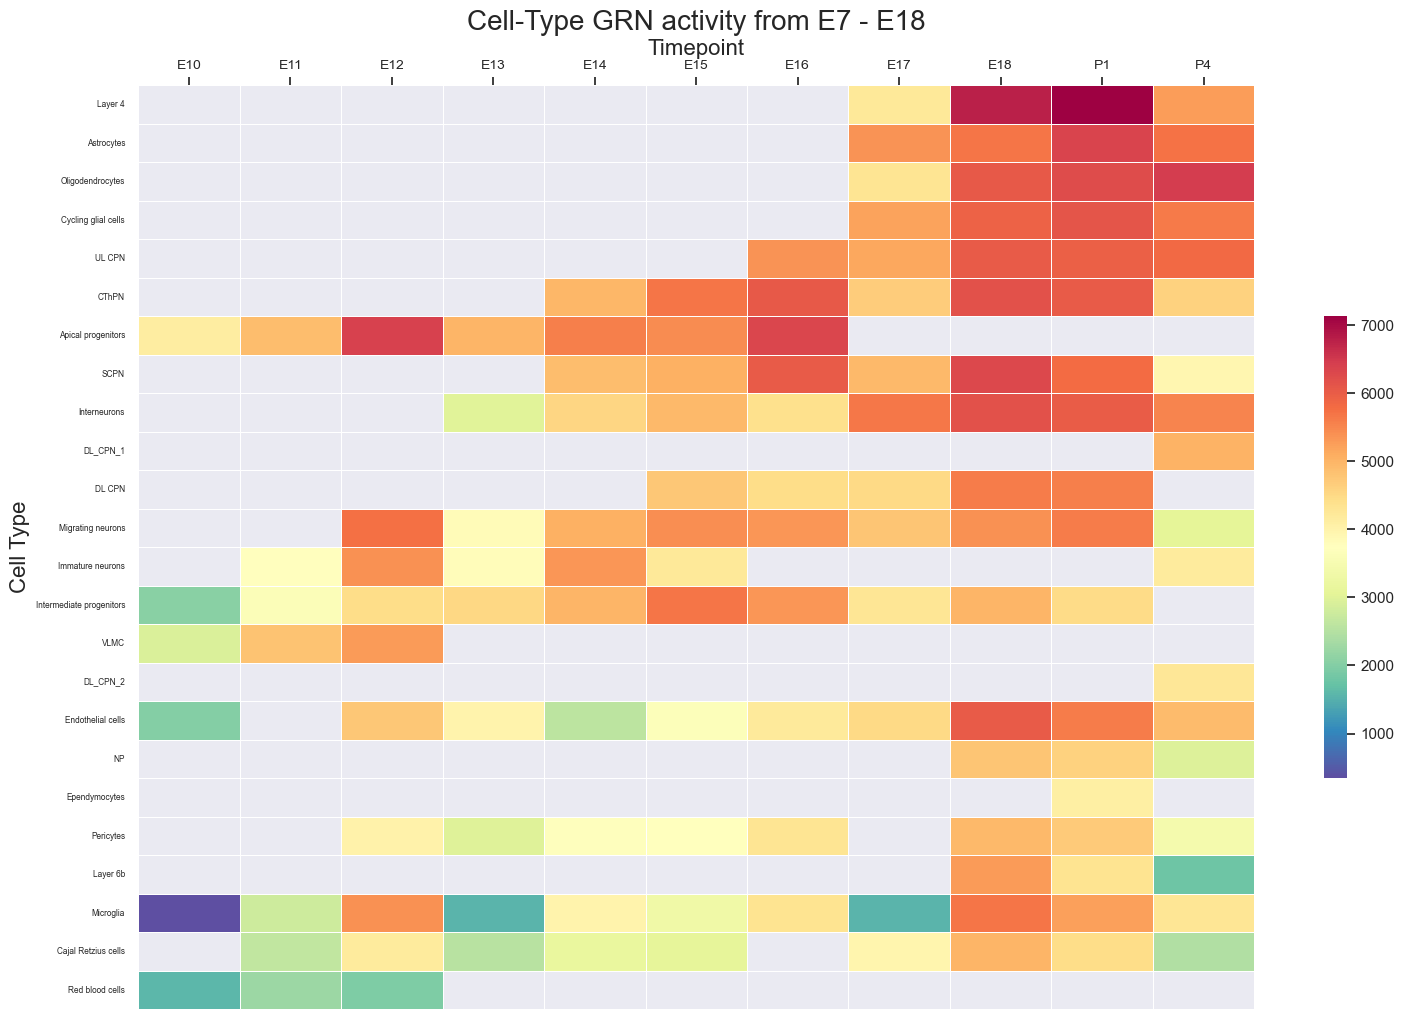

In [13]:
# Set heatmap parameters
cell_types = [os.path.splitext(os.path.basename(x))[0] for x in GRN_activity_combined.index]
sns.set(font_scale=1)
plt.figure(figsize=(18, 12))

# Draw heatmap with reduced font size for cell type labels and tick labels
sns.heatmap(GRN_activity_combined, cmap='Spectral_r', annot=False, fmt='g', linewidths=.5, 
            cbar_kws={"shrink": .5}, yticklabels=cell_types)

# Move xtick labels to top of heatmap
plt.gca().xaxis.set_ticks_position("top")

# Add x-axis label at top of graph
plt.xlabel('')
plt.gca().xaxis.set_label_position('top')
plt.gca().set_xlabel('Timepoint', fontsize=16)

# Adjust font size of cell type labels and timepoint labels
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Cell Type', fontsize=16)

# Reduce font size of cell type labels
plt.yticks(fontsize=6)

# Add color bar and title
plt.title('Cell-Type GRN activity from E7 - E18', fontsize=20)


# Save heatmap
#plt.savefig('', dpi=300)

# Show plot
plt.show()


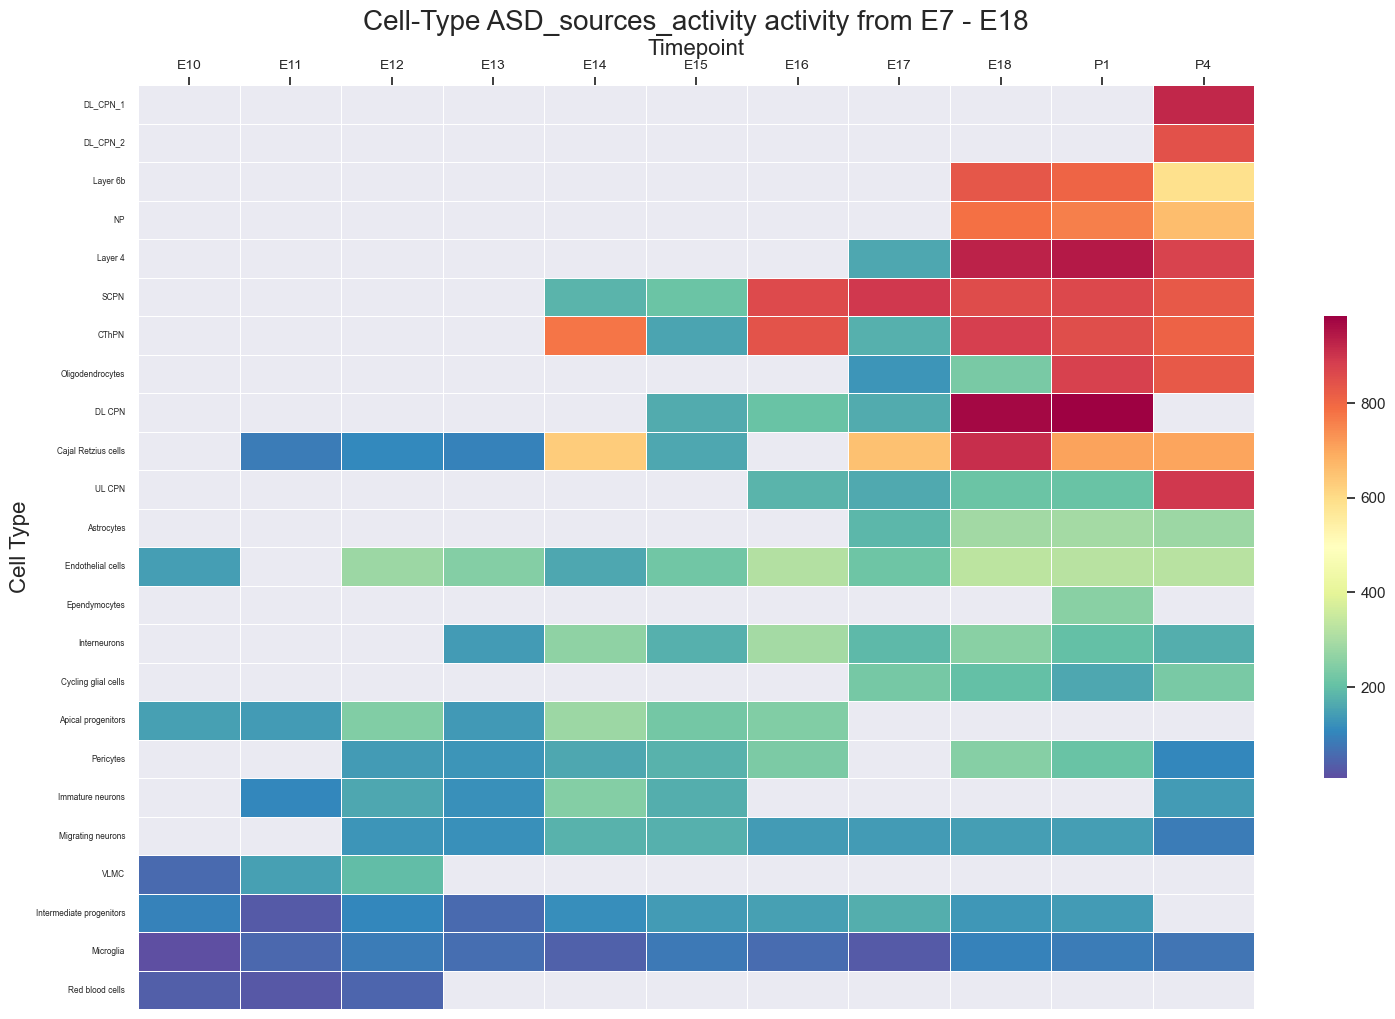

In [14]:
# Select 'ASD_sources' from each DataFrame
ASD_sources_activity_dfs = {key: df['ASD_sources'] for key, df in combined_dfs.items()}

# Combine into a single DataFrame
ASD_sources_activity_combined = pd.concat(ASD_sources_activity_dfs, axis=1)

# Rename columns to include timepoint
#GRN_activity_combined.columns = [f'{key} GRN_Activity' for key in GRN_activity_combined.columns]


# Calculate the average across all columns
averages = ASD_sources_activity_combined.mean(axis=1)

# Sort the dataframe based on the average values in descending order
ASD_sources_activity_combined = ASD_sources_activity_combined.loc[averages.sort_values(ascending=False).index]
# Set heatmap parameters

# Sort
import pandas as pd

# Define the desired column order
desired_order = ['E10', 'E11', 'E12', 'E13', 'E14', 'E15',
                 'E16', 'E17', 'E18', 'P1', 'P4']

# Reorder the DataFrame columns
ASD_sources_activity_combined = ASD_sources_activity_combined.reindex(columns=desired_order)


cell_types = [os.path.splitext(os.path.basename(x))[0] for x in ASD_sources_activity_combined.index]
sns.set(font_scale=1)
plt.figure(figsize=(18, 12))

# Draw heatmap with reduced font size for cell type labels and tick labels
sns.heatmap(ASD_sources_activity_combined, cmap='Spectral_r', annot=False, fmt='g', linewidths=.5, 
            cbar_kws={"shrink": .5}, yticklabels=cell_types)

# Move xtick labels to top of heatmap
plt.gca().xaxis.set_ticks_position("top")

# Add x-axis label at top of graph
plt.xlabel('')
plt.gca().xaxis.set_label_position('top')
plt.gca().set_xlabel('Timepoint', fontsize=16)

# Adjust font size of cell type labels and timepoint labels
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Cell Type', fontsize=16)

# Reduce font size of cell type labels
plt.yticks(fontsize=6)

# Add color bar and title
plt.title('Cell-Type ASD_sources_activity activity from E7 - E18', fontsize=20)


# Save heatmap
#plt.savefig('', dpi=300)

# Show plot
plt.show()


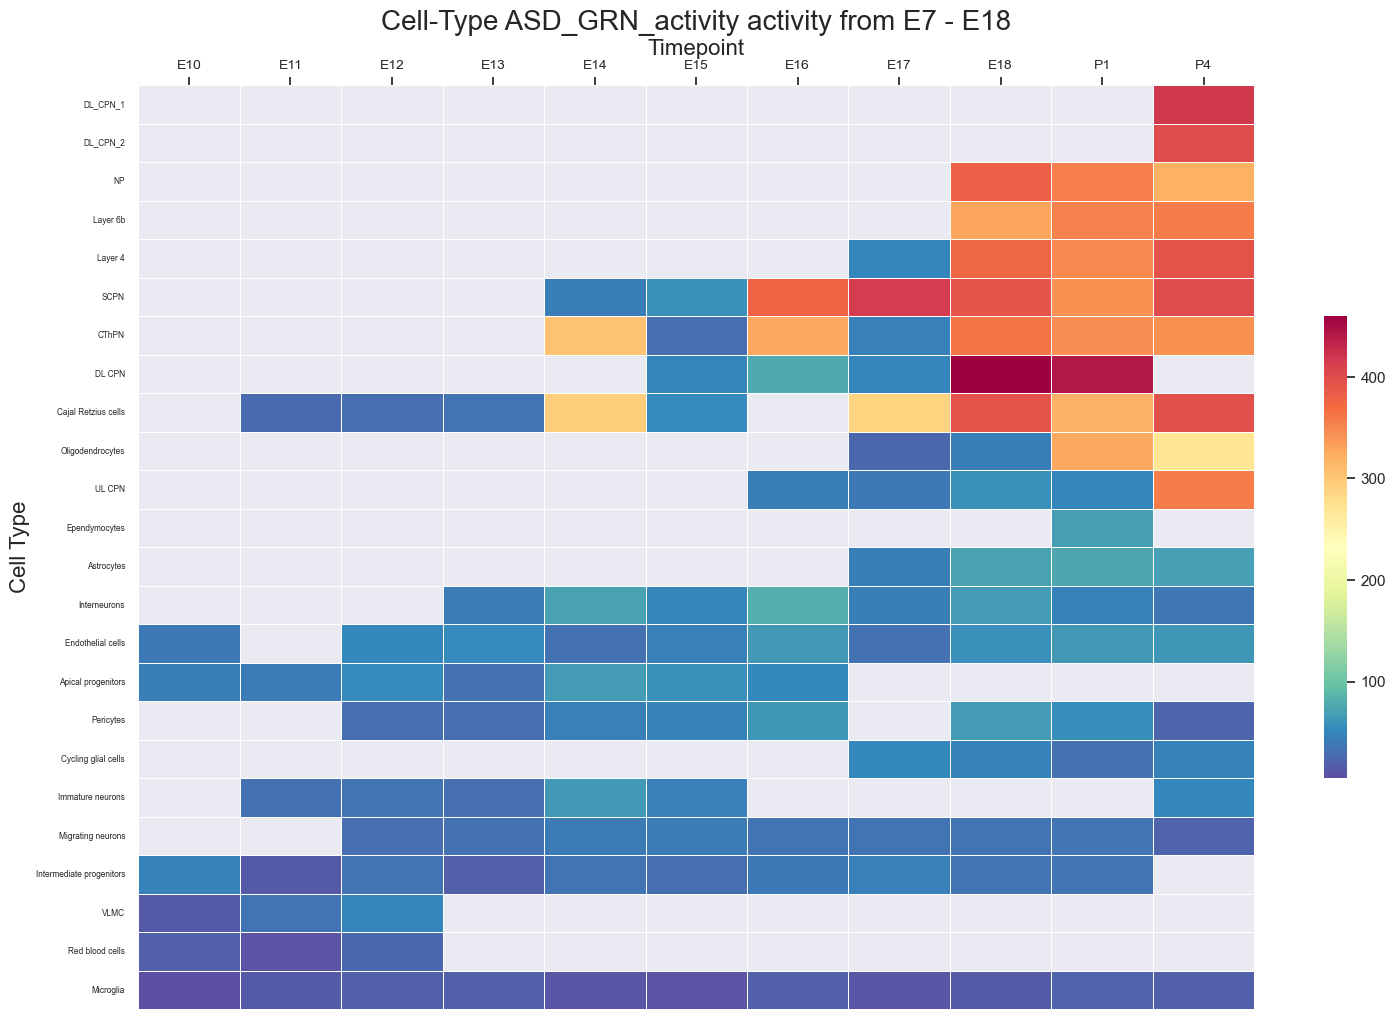

In [15]:
# Select 'ASD_GRN_activity' from each DataFrame
ASD_GRN_activity_dfs = {key: df['ASD_GRN_activity'] for key, df in combined_dfs.items()}

# Combine into a single DataFrame
ASD_GRN_activity_combined = pd.concat(ASD_GRN_activity_dfs, axis=1)

# Rename columns to include timepoint
#GRN_activity_combined.columns = [f'{key} GRN_Activity' for key in GRN_activity_combined.columns]


# Calculate the average across all columns
averages = ASD_GRN_activity_combined.mean(axis=1)

# Sort the dataframe based on the average values in descending order
ASD_GRN_activity_combined = ASD_GRN_activity_combined.loc[averages.sort_values(ascending=False).index]
# Set heatmap parameters

# Define the desired column order
desired_order = ['E10', 'E11', 'E12', 'E13', 'E14', 'E15',
                 'E16', 'E17', 'E18', 'P1', 'P4']

# Reorder the DataFrame columns
ASD_GRN_activity_combined = ASD_GRN_activity_combined.reindex(columns=desired_order)

cell_types = [os.path.splitext(os.path.basename(x))[0] for x in ASD_GRN_activity_combined.index]
sns.set(font_scale=1)
plt.figure(figsize=(18, 12))

# Draw heatmap with reduced font size for cell type labels and tick labels
sns.heatmap(ASD_GRN_activity_combined, cmap='Spectral_r', annot=False, fmt='g', linewidths=.5, 
            cbar_kws={"shrink": .5}, yticklabels=cell_types)

# Move xtick labels to top of heatmap
plt.gca().xaxis.set_ticks_position("top")

# Add x-axis label at top of graph
plt.xlabel('')
plt.gca().xaxis.set_label_position('top')
plt.gca().set_xlabel('Timepoint', fontsize=16)

# Adjust font size of cell type labels and timepoint labels
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Cell Type', fontsize=16)

# Reduce font size of cell type labels
plt.yticks(fontsize=6)

# Add color bar and title
plt.title('Cell-Type ASD_GRN_activity activity from E7 - E18', fontsize=20)


# Save heatmap
#plt.savefig('', dpi=300)

# Show plot
plt.show()


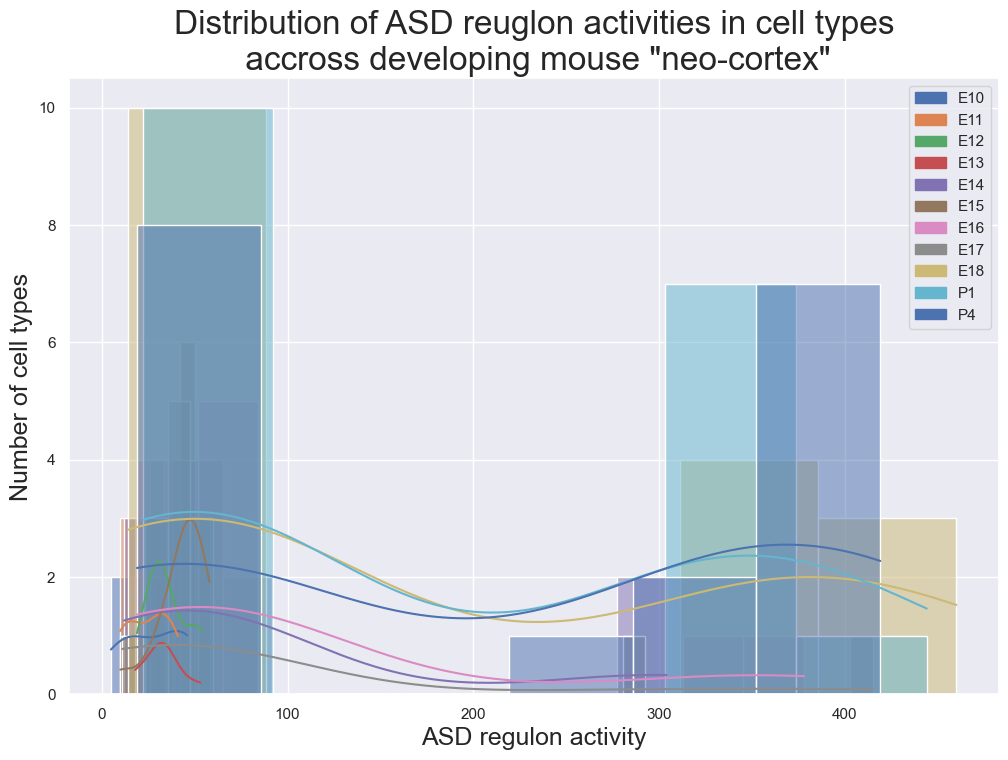

In [16]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Create an empty list to hold the legend patches
patches = []

# Iterate over each column in the DataFrame
for column in ASD_GRN_activity_combined.columns:
    # Select the column values
    data = ASD_GRN_activity_combined[column].values.flatten()

    # Filter out the non-zero values
    data = data[data != 0]

    # Create a histogram for the column
    sns.histplot(data=data, kde=True)

    # Get the color of the KDE line (which is darker than histogram)
    line_color = plt.gca().lines[-1].get_color()

    # Add a patch to the list for the legend
    patches.append(mpatches.Patch(color=line_color, label=column))

# Set plot labels and title
plt.xlabel('ASD regulon activity', size =18)
plt.ylabel('Number of cell types', size=18)
plt.title('Distribution of ASD reuglon activities in cell types\n accross developing mouse "neo-cortex"', size =24)

# Show the legend
plt.legend(handles=patches)


# Uncomment the following line if you want to save the plot
#plt.savefig('', dpi=300)
# Show the plot
plt.show()


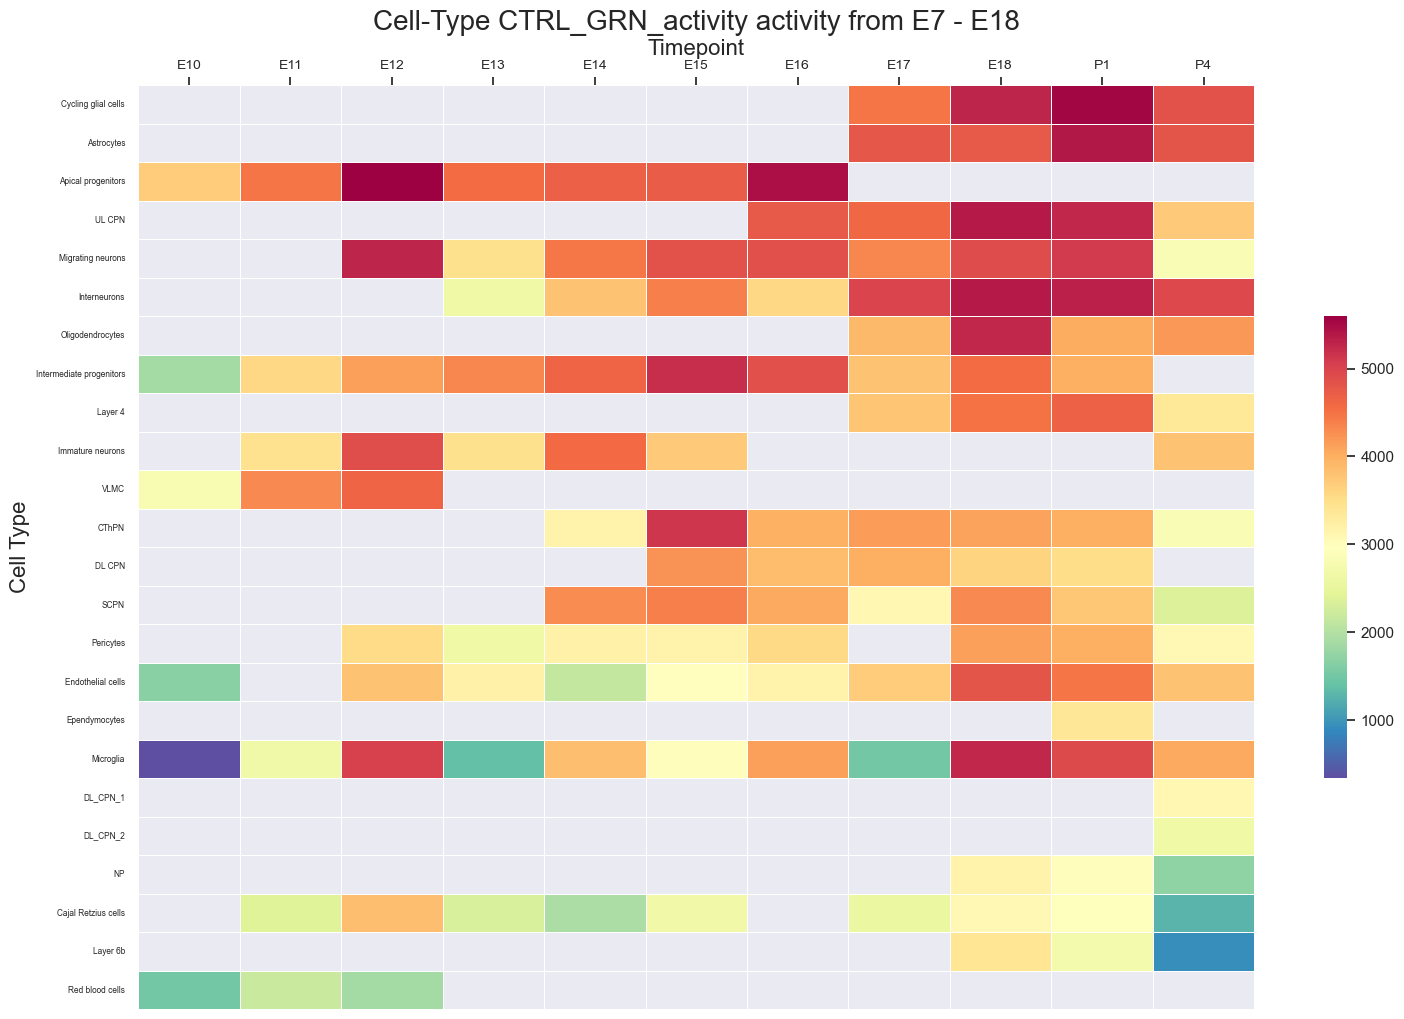

In [17]:
# Select 'GRN_Activity' from each DataFrame
CTRL_GRN_activity_dfs = {key: df['Ctrl_GRN_activity'] for key, df in combined_dfs.items()}

# Combine into a single DataFrame
CTRL_GRN_activity_combined = pd.concat(CTRL_GRN_activity_dfs, axis=1)

# Rename columns to include timepoint
#GRN_activity_combined.columns = [f'{key} GRN_Activity' for key in GRN_activity_combined.columns]


# Calculate the average across all columns
averages = CTRL_GRN_activity_combined.mean(axis=1)

# Sort the dataframe based on the average values in descending order
CTRL_GRN_activity_combined = CTRL_GRN_activity_combined.loc[averages.sort_values(ascending=False).index]
# Set heatmap parameters

# Sort
# Define the desired column order
desired_order = ['E10', 'E11', 'E12', 'E13', 'E14', 'E15',
                 'E16', 'E17', 'E18', 'P1', 'P4']

# Reorder the DataFrame columns
CTRL_GRN_activity_combined = CTRL_GRN_activity_combined.reindex(columns=desired_order)


cell_types = [os.path.splitext(os.path.basename(x))[0] for x in CTRL_GRN_activity_combined.index]
sns.set(font_scale=1)
plt.figure(figsize=(18, 12))

# Draw heatmap with reduced font size for cell type labels and tick labels
sns.heatmap(CTRL_GRN_activity_combined, cmap='Spectral_r', annot=False, fmt='g', linewidths=.5, 
            cbar_kws={"shrink": .5}, yticklabels=cell_types)

# Move xtick labels to top of heatmap
plt.gca().xaxis.set_ticks_position("top")

# Add x-axis label at top of graph
plt.xlabel('')
plt.gca().xaxis.set_label_position('top')
plt.gca().set_xlabel('Timepoint', fontsize=16)

# Adjust font size of cell type labels and timepoint labels
plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Cell Type', fontsize=16)

# Reduce font size of cell type labels
plt.yticks(fontsize=6)

# Add color bar and title
plt.title('Cell-Type CTRL_GRN_activity activity from E7 - E18', fontsize=20)


# Save heatmap
#plt.savefig('', dpi=300)

# Show plot
plt.show()


## OLS regression analysis

In [18]:
# Reshape 'ASD_GRN_activity_combined' DataFrame from wide format to long format.
# 'Cell-type' is kept as identifier variable.
ASD_GRN_activity_long = ASD_GRN_activity_combined.reset_index().melt(id_vars='Cell-type', var_name='time', value_name='ASD_activity')

# Reshape 'GRN_activity_combined' DataFrame from wide format to long format.
# 'Cell-type' is kept as identifier variable.
GRN_activity_long = GRN_activity_combined.reset_index().melt(id_vars='Cell-type', var_name='time', value_name='GRN_activity')

# Merge the two reshaped dataframes on 'Cell-type' and 'time' columns.
# 'left' merge is used, so all rows from the first (left) dataframe and only the matched rows from the second (right) dataframe will be returned.
df = pd.merge(ASD_GRN_activity_long, GRN_activity_long,  how='left', left_on=['Cell-type','time'], right_on = ['Cell-type','time'])

# Define the order of the time stages
column_order = ['E10', 'E11', 'E12', 'E13', 'E14', 'E15','E16', 'E17', 'E18', 'P1', 'P4']

# Map the time stages to a numerical value for use in regression
time_dict = {col: i+1 for i, col in enumerate(column_order)}
df['time'] = df['time'].map(time_dict)

# Specify the Ordinary Least Squares (OLS) model.
# The model will regress 'ASD_activity' on 'GRN_activity' and 'time'.
model = smf.ols(formula='ASD_activity ~ GRN_activity + time', data=df)

# Fit the model using robust covariance estimation method 'HC3'.
# This method provides a robust standard errors in the case of heteroscedasticity.
results = model.fit(cov_type='HC3')

# Get the residuals from the model.
residuals = results.resid

# Printing the summary statistics of the model.
print(results.summary())

# Adding the residuals to the dataframe.
df['residuals'] = results.resid


                            OLS Regression Results                            
Dep. Variable:           ASD_activity   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     23.13
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           2.56e-09
Time:                        17:04:37   Log-Likelihood:                -826.69
No. Observations:                 133   AIC:                             1659.
Df Residuals:                     130   BIC:                             1668.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -43.6137     32.667     -1.335   

In [19]:
# Revert time-point dictionary
inverse_time_dict = {v: k for k, v in time_dict.items()}
df['time'] = df['time'].map(inverse_time_dict)
df

,Cell-type,time,ASD_activity,GRN_activity,residuals
0,DL_CPN_1.csv,E10,NaN,NaN,NaN
1,DL_CPN_2.csv,E10,NaN,NaN,NaN
2,NP.csv,E10,NaN,NaN,NaN
3,Layer 6b.csv,E10,NaN,NaN,NaN
4,Layer 4.csv,E10,NaN,NaN,NaN
...,...,...,...,...,...
259,Migrating neurons.csv,P4,21.0,3068.0,-176.601921
260,Intermediate progenitors.csv,P4,NaN,NaN,NaN
261,VLMC.csv,P4,NaN,NaN,NaN
262,Red blood cells.csv,P4,NaN,NaN,NaN


Investigate fit and residuals

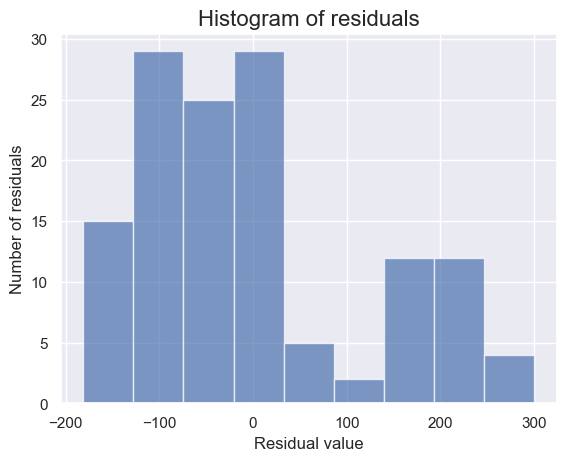

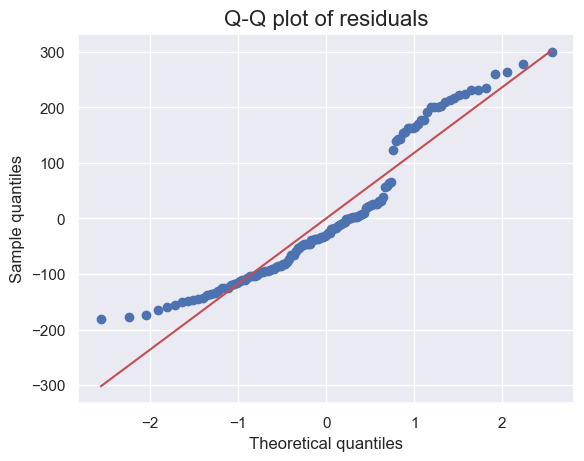

Mean of residuals: -3.312304482490693e-14
Residuals are not normally distributed (according to the Shapiro-Wilk test).


In [20]:
# Plot the histogram of residuals
plt.hist(residuals, bins='auto', density=False, alpha=0.7)
plt.xlabel('Residual value', size=12)
plt.ylabel('Number of residuals', size=12)
plt.title('Histogram of residuals', size=16)
#plt.savefig('', dpi=300)

plt.show()

# Plot the Q-Q plot of residuals
qqplot = stats.probplot(residuals, dist="norm", plot=plt)
plt.xlabel('Theoretical quantiles', size=12)
plt.ylabel('Sample quantiles', size=12)
plt.title('Q-Q plot of residuals', size=16)
#plt.savefig('', dpi=300)

plt.show()

# Perform the Shapiro-Wilk test for normality
_, p_value = stats.shapiro(residuals)
# Calculate the mean of residuals
residual_mean = residuals.mean()
print("Mean of residuals:", residual_mean)

# Set the significance level (alpha)
alpha = 0.05

# Check if the p-value is above the significance level
if p_value > alpha:
    print("Residuals are normally distributed (according to the Shapiro-Wilk test).")
else:
    print("Residuals are not normally distributed (according to the Shapiro-Wilk test).")



In [21]:
# Add residuals to original DataFrame
df['residuals'] = residuals

# Sort the DataFrame by residuals
df_sorted_by_residuals = df.sort_values(by='residuals')


from IPython.display import display, HTML

# Enable scrolling
pd.set_option('display.max_rows', None)

# Convert DataFrame to HTML and set a CSS property to make the table scrollable
df_html = df_sorted_by_residuals.to_html()
styled_df_html = '<style> .dataframe {height: 400px; overflow-y: auto;}</style>' + df_html

# Display HTML
display(HTML(styled_df_html))


,Cell-type,time,ASD_activity,GRN_activity,residuals
263,Microglia.csv,P4,19.0,4284.0,-181.046823
259,Migrating neurons.csv,P4,21.0,3068.0,-176.601921
256,Pericytes.csv,P4,24.0,3433.0,-174.335794
253,Interneurons.csv,P4,38.0,5540.0,-164.572149
239,Microglia.csv,P1,22.0,5240.0,-158.601054
257,Cycling glial cells.csv,P4,47.0,5641.0,-155.775221
258,Immature neurons.csv,P4,50.0,4183.0,-149.843751
233,Cycling glial cells.csv,P1,33.0,6110.0,-149.350285
215,Microglia.csv,E18,14.0,5700.0,-146.158023
235,Migrating neurons.csv,P1,36.0,5605.0,-145.334927


Visualize ASD regulon activity as a function of time

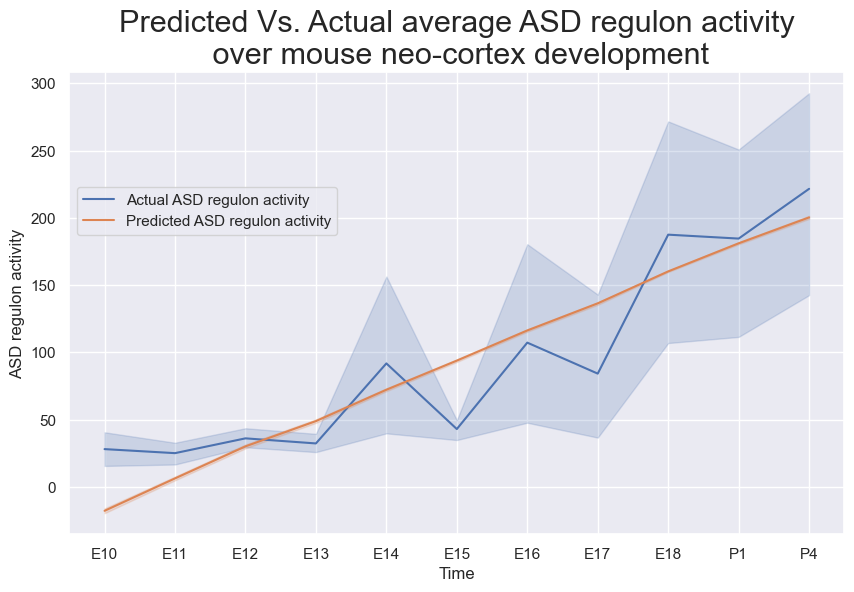

In [25]:
# Get the predicted values
df['predicted_ASD_activity'] = results.fittedvalues

# Create a plot
plt.figure(figsize=(10, 6))

# Plot actual ASD activity
sns.lineplot(x=df['time'], y=df['ASD_activity'], label='Actual ASD regulon activity')

# Plot predicted ASD activity (GRN activity held constant)
sns.lineplot(x=df['time'], y=df['predicted_ASD_activity'], label='Predicted ASD regulon activity')

plt.title('Predicted Vs. Actual average ASD regulon activity\n over mouse neo-cortex development', size =22)
plt.xlabel('Time', size=12)
plt.ylabel('ASD regulon activity', size=12)
plt.legend()
# Move legend to the left of the plot
plt.legend(loc='center left', bbox_to_anchor=(0., 0.7))
plt.savefig('', dpi=300)

plt.show()


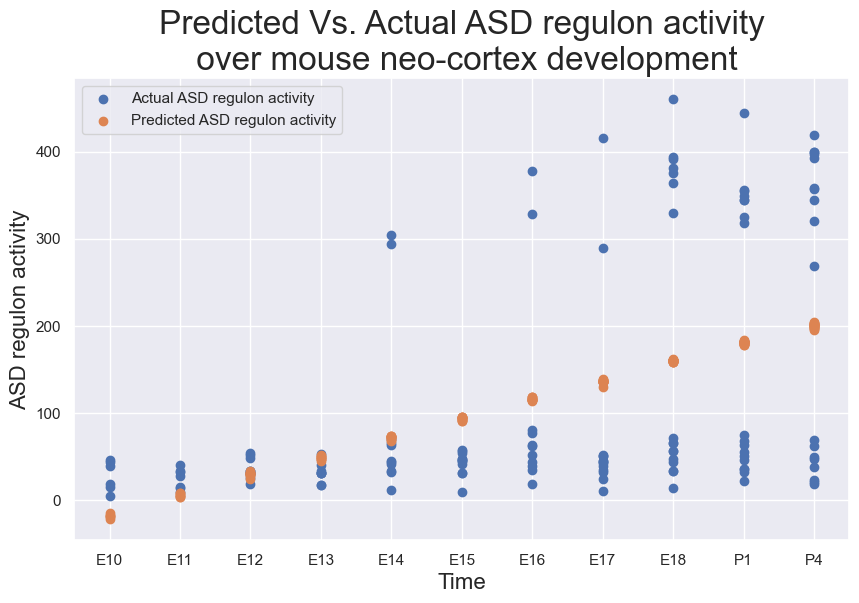

In [27]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot actual ASD activity
plt.scatter(df['time'], df['ASD_activity'], label='Actual ASD regulon activity')

# Plot predicted ASD activity
plt.scatter(df['time'], df['predicted_ASD_activity'], label='Predicted ASD regulon activity')

plt.title('Predicted Vs. Actual ASD regulon activity\n over mouse neo-cortex development', size =24)
plt.xlabel('Time', size=16)
plt.ylabel('ASD regulon activity', size=16)
plt.legend()

# Uncomment the following line if you want to save the plot
plt.savefig('', dpi=300)

plt.show()


## END 